In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import random
import bisect
import re
import numpy as np


from collections import defaultdict
from collections import Counter
import random
import sys
import pickle

sys.path.insert(0,'../decryption')
sys.path.insert(0,'../encryption')
sys.path.insert(0,'../dictionaries')

import encrypt
import decrypt
import alphabet
import frequency

_ALPHABET = " abcdefghijklmnopqrstuvwxyz"

In [2]:
# simulation of problem
TEST_KEY_MAPPING = encrypt.generate_key_mapping()
TEST_CHAR_MAPPING = encrypt.char_key_mapping_from_key_mapping(TEST_KEY_MAPPING)

assert len(set(TEST_KEY_MAPPING)) == 27

TEST_PLAIN_TEXTS = []
with open('../dictionaries/official_dictionary_1_cleaned.txt','r') as f:
    content = f.readlines()
    for line in content:
        TEST_PLAIN_TEXTS.append(line.strip())

TEST_PLAIN_TEXTS[3] += ' '
TEST_PROBABILITY = 0.1
ciphers = [encrypt.encrypt(msg,TEST_KEY_MAPPING,TEST_PROBABILITY) for msg in TEST_PLAIN_TEXTS]

# pick a random cipher and start working with it. (We should not know the original plain text)
r = random.randint(0,len(ciphers)-1)
cipher_txt = ciphers[r]
test_plain_text = TEST_PLAIN_TEXTS[r]

In [3]:
with open('../dictionaries/official_dictionary_2_cleaned.txt') as file:
    lines = file.readlines()

DICTIONARY_LIST = []
DICTIONARY_SET = set()

for line in lines:
    line = re.sub('[^A-Za-z0-9]+', '', line.strip())
    DICTIONARY_LIST.append(line)
    DICTIONARY_SET.add(line)

In [4]:
def generate_test_one_cipher(p):
    num_key_mapping = encrypt.generate_key_mapping()
    char_key_mapping = encrypt.char_key_mapping_from_key_mapping(num_key_mapping)
    r = random.randint(0,len(ciphers)-1)
    cipher = encrypt.encrypt(TEST_PLAIN_TEXTS[r],num_key_mapping,p)
    return TEST_PLAIN_TEXTS[r],cipher,char_key_mapping,num_key_mapping

def generate_test_two_cipher(p):
    num_key_mapping = encrypt.generate_key_mapping()
    char_key_mapping = encrypt.char_key_mapping_from_key_mapping(num_key_mapping)
    plain_txt = " ".join(random.choices(DICTIONARY_LIST,k=200))[:500]
    cipher = encrypt.encrypt(plain_txt,num_key_mapping,p)
    return plain_txt,cipher,char_key_mapping,num_key_mapping
    

In [5]:
plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_two_cipher(0.2)

In [6]:
def build_rel_dist(text):
    rel_dist = defaultdict(list)
    rel_num = defaultdict(list)
    for j,c in enumerate(text):
        rel_dist[c].append((j/len(text)))
        rel_num[c].append(j)
    return rel_dist,rel_num

def get_diff(arr):
    diff = []
    for i in range(1,len(arr)):
        diff.append(round(arr[i]-arr[i-1],4))
    return diff

def get_char_diffs_data(char_rel_num,rel_num,l):
    left = []
    right = []
    avg_num_diff = []
    for i,num in enumerate(rel_num):
        char_closest_right = bisect.bisect_left(char_rel_num,num)
        char_closest_left = char_closest_right-1
        if char_closest_left == -1:
            lo = 0
        else:
            lo = char_rel_num[char_closest_left]
        if char_closest_right == len(char_rel_num):
            hi = l
        else:
            hi = char_rel_num[char_closest_right]
        left.append(num-lo)
        right.append(hi-num)
        avg_num_diff.append(right[-1] - left[-1])
        
    return left,right,avg_num_diff

def append(data,df):
    l = len(df)
    for k,v in data.items():
        df.loc[l,k] = v
        
def populate_dist_data(dist,prefix,data = dict()):
    data[prefix + '_mean'] = np.mean(dist)
    data[prefix + '_std'] = np.std(dist)
    
    max_moments = 3
    for i in range(2,max_moments+1):
        data[prefix+str(i)+'_num_moment'] = stats.moment(dist,i)
    
    return data


# features: space character frequency, last character frequency, difference from 500
# stats of space char freq diff, last char freq diff
# stats of char diffs data of last char and space char
# covariance of space char and last char data

def get_test_diff_data(c_rel_dist,c_rel_num,c_rel_num_diff,c_rel_dist_diff,space_data_c,last_char_mapping):
    data = dict()
    data['space_char_freq'] = len(c_rel_num[space_char])
    data['last_char_freq'] = len(c_rel_num[last_char_mapping])
    data['diff'] = len(cipher) - 500

    populate_dist_data(c_rel_num_diff[space_char],'space_diff',data)
    populate_dist_data(c_rel_num_diff[last_char_mapping],'last_char_diff',data)

    l = min(len(c_rel_num[space_char]),len(c_rel_num[last_char_mapping]))
    if l>1:
        data['last_space_num_first_cov'] = np.cov(c_rel_num[space_char][:l],c_rel_num[last_char_mapping][:l])[0][1]
    return data
    

In [7]:
# get distributions for cipher
c_rel_dist,c_rel_num = build_rel_dist(cipher)
c_rel_num_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_num.items()})
c_rel_dist_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_dist.items()})

space_char = decrypt.get_space_key_value(cipher)
space_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[space_char],c_rel_num[c],len(cipher)) for c in _ALPHABET})

last_char_mapping = cipher[-1]
last_char_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[last_char_mapping],c_rel_num[c],len(cipher)) for c in _ALPHABET})
    

In [8]:
cols = [
    'space_char_freq',
     'last_char_freq',
     'diff',
     'space_diff_mean',
     'space_diff_std',
     'space_diff2_num_moment',
     'space_diff3_num_moment',
     'last_char_diff_mean',
     'last_char_diff_std',
     'last_char_diff2_num_moment',
     'last_char_diff3_num_moment',
     'last_space_num_first_cov',
        'result'
]


In [9]:
def iter_tests(p,num):
    for _ in range(num):
        plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_one_cipher(p)
        yield plain_txt,cipher,char_key_mapping,num_key_mapping,True
        
        plain_txt,cipher,char_key_mapping,num_key_mapping = generate_test_two_cipher(p)
        yield plain_txt,cipher,char_key_mapping,num_key_mapping,False

def iter_prob_tests(pmin,pmax,step,num):
    for prob in range(pmin,pmax+1,step):
        print('generating for prob',prob)
        for plain_txt,cipher,char_key_mapping,num_key_mapping,result in iter_tests(prob/100,num):
            yield plain_txt,cipher,char_key_mapping,num_key_mapping,result

In [72]:
# df = pd.DataFrame(columns = cols)
for plain_txt,cipher,char_key_mapping,num_key_mapping,result in iter_prob_tests(36,50,1,300):
    # get distributions for cipher
    c_rel_dist,c_rel_num = build_rel_dist(cipher)
    c_rel_num_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_num.items()})
    c_rel_dist_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_dist.items()})

    space_char = decrypt.get_space_key_value(cipher)
    space_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[space_char],c_rel_num[c],len(cipher)) for c in _ALPHABET})

    last_char_mapping = cipher[-1]
    last_char_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[last_char_mapping],c_rel_num[c],len(cipher)) for c in _ALPHABET})
    
    data = get_test_diff_data(c_rel_dist,c_rel_num,c_rel_num_diff,c_rel_dist_diff,space_data_c,last_char_mapping)
    data['result'] = result
    
    append(data,df)
    
    

generating for prob 36
generating for prob 37
generating for prob 38
generating for prob 39
generating for prob 40
generating for prob 41
generating for prob 42
generating for prob 43
generating for prob 44
generating for prob 45
generating for prob 46
generating for prob 47
generating for prob 48
generating for prob 49
generating for prob 50


In [73]:
df = df.fillna(0)

In [74]:
# build a model
import torch
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [75]:
output_idx = list(df.columns).index('result')
input_cols = list(df.columns)
input_cols.remove('result')
X = df.loc[:,input_cols].values
y = df.iloc[:,output_idx].values.reshape(-1,1).astype(np.float64)


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.20)
num_feat = X_train_raw.shape[1]

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = torch.from_numpy(scaler.transform(X_train_raw)).float()
X_test = torch.from_numpy(scaler.transform(X_test_raw)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [76]:
train_dataset = TensorDataset(X_train,y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True) # create your dataloader

test_dataset = TensorDataset(X_test,y_test) # create your datset
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=True) # create your dataloader

In [77]:
num_feat = len(X_train[0])

In [78]:


num_feat = len(X_train[0])
class NeuralNet(torch.nn.Module): 
    def __init__(self):
        super(NeuralNet,self).__init__()

        self.relu = torch.nn.ReLU()
        
        self.lin1 = torch.nn.Linear(num_feat, 16)
        
        self.lin2 =torch.nn.Linear(16, 64)
        
        self.lin3 =torch.nn.Linear(64, 16)
        
        self.lin4 =torch.nn.Linear(16, 1)
        
        self.out = torch.nn.Sigmoid()
        
        self.float()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        
        x = self.lin2(x)
        x = self.relu(x)
        
        x = self.lin3(x)
        x = self.relu(x)
        
        x = self.lin4(x)
        x = self.out(x)
        
        return x

net = NeuralNet()
loss = torch.nn.BCELoss() # pass output, target
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)


In [88]:
TEST_PLAIN_TEXTS

['underwaists wayfarings fluty analgia refuels transcribing nibbled okra buttonholer venalness hamlet praus apprisers presifted cubital walloper dissembler bunting wizardries squirrel preselect befitted licensee encumbrances proliferations tinkerer egrets recourse churl kolinskies ionospheric docents unnatural scuffler muches petulant acorns subconscious xyster tunelessly boners slag amazement intercapillary manse unsay embezzle stuccoer dissembles batwing valediction iceboxes ketchups phonily con',
 'rhomb subrents brasiers render avg tote lesbian dibbers jeopardy struggling urogram furrowed hydrargyrum advertizing cheroots goons congratulation assaulters ictuses indurates wingovers relishes briskly livelihoods inflatable serialized lockboxes cowers holster conciliating parentage yowing restores conformities marted barrettes graphically overdevelop sublimely chokey chinches abstracts rights hockshops bourgeoisie coalition translucent fiascoes panzer mucus capacitated stereotyper omaha

In [87]:
generate_test_one_cipher(0.1)

('underwaists wayfarings fluty analgia refuels transcribing nibbled okra buttonholer venalness hamlet praus apprisers presifted cubital walloper dissembler bunting wizardries squirrel preselect befitted licensee encumbrances proliferations tinkerer egrets recourse churl kolinskies ionospheric docents unnatural scuffler muches petulant acorns subconscious xyster tunelessly boners slag amazement intercapillary manse unsay embezzle stuccoer dissembles batwing valediction iceboxes ketchups phonily con',
 'jkmypigobwcbqiguhogpokebqhtjcuqgkgteogqpyhjkytbqcfpgkbwpovokkeqkovvtymqxrpgqvjccxknoxltypqachy kgtkykbbqngaldtycqzpgjbqgzzpobypbqzpybohcymqwjvocgntqigttbxztyepqmobvbylvtypqvjkcokeqgiofgpmcpoybqb wjoppytqzpybytywcqvyhoccypmqtowykbyyqoykwjlvpgkwybqzpxtohyypgjcoxkobqcopkrypypqye txpycbqpywrxjpbyqvwnjptqrxttokbroycbqqoxkxbzfnypowqmxowykcbqjkkgcjpgtqjbwjhuhtypqljwnybqzycjtgkcqgwlxpkbqbjvwuxkbwosxjbqdubcypqcjkytybbtuqvxkypbqbtgeqgjwlgfylykcqolkcsypxwgzottgpuqlxgkbbyqjkbguqylvyfftyqbcjcwwxypqmob

In [79]:
train_loss_history = []
test_loss_history = []

In [83]:
epochs = 200
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(train_dataloader):
        net.train()
        a_inp, a_out = data
        optimizer.zero_grad()
        predicted_output = net(a_inp)
        fit = loss(predicted_output,a_out) # loss(p_out,a_out)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()

    for i, data in enumerate(test_dataloader):
        net.eval()
        with torch.no_grad():
            a_inp, a_out = data
            predicted_output = net(a_inp)
            fit = loss(predicted_output,a_out)
            test_loss += fit.item()
            predicted = torch.max(predicted_output.data, 1)

    train_loss = train_loss/len(train_dataloader)
    test_loss = test_loss/len(test_dataloader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.2108093746442785, Test loss 0.21991053132474908
Epoch 1, Train loss 0.2125955755272078, Test loss 0.21973804197684452
Epoch 2, Train loss 0.21098150817170627, Test loss 0.23027230330368006
Epoch 3, Train loss 0.2112044927583822, Test loss 0.21861288718605687


KeyboardInterrupt: 

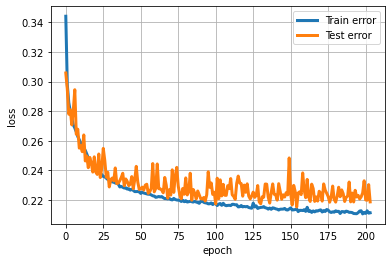

In [84]:
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [85]:
correct = 0
total = 0

net.eval()
for i, data in enumerate(test_dataloader):
    with torch.no_grad():
        a_inp, a_out = data
        predicted_output = net(a_inp)
        p_arr = predicted_output.detach().numpy()
        a_out = a_out.detach().numpy()
        for i in range(len(a_out)):
            if abs(p_arr[i] - a_out[i])<0.5:
                correct += 1
            total += 1

print('accuracy is',correct/total)

accuracy is 0.9001049073318569


In [34]:
# import pickle
# cols_one = input_cols
# with open('columns_diff_test.pkl', 'wb') as handle:
#     pickle.dump(cols_one, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('scaler_diff_test.pkl', 'wb') as handle:
#     pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# torch.save(net.state_dict(),'model_diff_test.state')

In [54]:
correct = 0
total = 0
for t_out,a_out in zip(try_out,df['result'].iloc[:]):
    res = (t_out.item() > 0.5)
    if res == a_out:
        correct += 1
    total += 1